## Exploratory Data Analysis

In [0]:
PATH = 'transport_data.csv'

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [0]:
import seaborn as sns

In [5]:
bus_df = pd.read_csv(PATH)
bus_df.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.219528,59.954617,1511956827,1511956746,-
2,30.409101,59.931679,1511956827,1511956747,-
3,30.293602,59.938892,1511956827,1511956759,-
4,30.360102,59.931103,1511956827,1511956767,-


In [0]:
bus_df.shape

(58665, 5)

In [0]:
bus_df['request_ts_datetime'] = bus_df.request_ts.apply(lambda unix: pd.to_datetime(unix, unit='s'))
bus_df['trans_ts_datetime'] = bus_df.trans_ts.apply(lambda unix: pd.to_datetime(unix, unit='s'))

In [6]:
bus_df.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.219528,59.954617,1511956827,1511956746,-
2,30.409101,59.931679,1511956827,1511956747,-
3,30.293602,59.938892,1511956827,1511956759,-
4,30.360102,59.931103,1511956827,1511956767,-


In [0]:
bus_df['delay'] = bus_df.apply(axis=1, func=lambda row: row['request_ts'] - row['trans_ts'])

In [0]:
# bus_df['request_ts_datetime'].value_counts(sort=False).plot(kind='bar')

In [0]:
bus_df.label.value_counts()

-    43665
?     5000
0     4423
1     3372
2     2205
Name: label, dtype: int64

In [0]:
from sklearn import neighbors
import numpy as np
import xgboost

In [0]:
short_df = bus_df[['log','lat','label','request_ts','trans_ts']]

In [0]:
pred_df = short_df.loc[short_df['label'] == '?']

In [0]:
train_df = short_df.loc[short_df['label'].isin(['0','1','2'])]

In [0]:
train_df.shape


(10000, 5)

In [0]:
n_neighbors = 15
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(train_df[['log','lat']], train_df[['label']])

answ = np.array(clf.predict(pred_df[['log','lat']]))
print(answ)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [0]:
with open("output.txt", "w") as file:
    file.writelines("%s\n" % a for a in answ)

In [0]:
f = open("output.txt", 'r')
mas = f.readlines()
# print(mas)

In [0]:
def knn_to_file(neighbors, x, y, x_pred, filename):
    clf = neighbors.KNeighborsClassifier(neighbors)
    
    clf.fit(x, y)
    
    y_pred = np.array(clf.predict(x_pred))
    
    with open(filename, "w") as file:
        file.writelines("%s\n" % a for a in y_pred)

In [0]:
log_left = 30.306433
log_right = 30.404808

In [15]:
df_minus.head()

,log,lat,label,request_ts,trans_ts
1,30.219528,59.954617,-,1511956827,1511956746
2,30.409101,59.931679,-,1511956827,1511956747
3,30.293602,59.938892,-,1511956827,1511956759
4,30.360102,59.931103,-,1511956827,1511956767
5,30.309683,59.940006,-,1511956827,1511956769


In [0]:
df_minus = short_df.loc[short_df['label'] == '-']

df_not_nevsky_1 = df_minus.loc[df_minus['log'] < log_left]
df_not_nevsky_2 = df_minus.loc[df_minus['log'] > log_right]

df_not_nevsky = pd.concat([df_not_nevsky_1, df_not_nevsky_2])

clf = neighbors.KNeighborsClassifier(30)
clf.fit(train_df[['log','lat']], train_df[['label']])

y_pred = np.array(clf.predict(df_not_nevsky[['log','lat']]))

df_not_nevsky['label'] = y_pred
df_train = pd.concat([train_df, df_not_nevsky])
# knn_to_file(20, train_df[['log','lat']], train_df[['label']], df_not_nevsky[['log','lat']], "output_minus.txt")

In [0]:
df_train.head()

,log,lat,label,delay,trans_ts
0,30.295780,59.932167,0,233,1511956594
8,30.385973,59.944260,0,45,1511956782
13,30.374880,59.938213,1,25,1511956802
17,30.347544,59.932667,0,16,1511956811
23,30.312321,59.937405,2,7,1511956820


In [0]:
# df_train['delay'] = df_train.apply(axis=1, func=lambda row: row['delay'] % 30)
df_train['trans_ts_mod30'] = df_train.trans_ts.apply(lambda time: time % 30)

In [21]:
df_train.head()

,log,lat,label,request_ts,trans_ts,trans_ts_mod30
0,30.295780,59.932167,0,1511956827,1511956594,4
8,30.385973,59.944260,0,1511956827,1511956782,12
13,30.374880,59.938213,1,1511956827,1511956802,2
17,30.347544,59.932667,0,1511956827,1511956811,11
23,30.312321,59.937405,2,1511956827,1511956820,20


In [0]:
pred_df['trans_ts_mod30'] = pred_df.trans_ts.apply(lambda time: time % 30)

In [0]:
clf = neighbors.KNeighborsClassifier(150)
clf.fit( df_train[['log','lat','trans_ts_mod30']], df_train[['label']])
y_pred = np.array(clf.predict(pred_df[['log','lat','trans_ts_mod30']]))

with open("output_knn_150_delay_minus_trans_ts_mod30.txt", "w") as file:
        file.writelines("%s\n" % a for a in y_pred) 

#knn_to_file(50, df_train[['log','lat']], df_train[['label']], pred_df[['log','lat']] , "output_minus.txt")

In [0]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

In [0]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=250, learning_rate = 0.05, max_depth = 5, subsample = 0.8)
gbc.fit( df_train[['log','lat','trans_ts_mod30', 'request_ts','trans_ts']], df_train[['label']])
y_pred = np.array(gbc.predict(pred_df[['log','lat','trans_ts_mod30', 'request_ts','trans_ts']]))

with open("output_gbc_new_nev_simple_250_0.05_5_0.8_trans_ts_mod30_request_ts_trans_ts.txt", "w") as file:
        file.writelines("%s\n" % a for a in y_pred) 

In [34]:
xgb = xgboost.XGBRegressor(n_estimators=250, learning_rate=0.01, gamma=0, subsample=0.1,colsample_bytree=1, max_depth=30)
xgb.fit( df_train[['log','lat','trans_ts_mod30', 'request_ts','trans_ts']], df_train[['label']])
y_pred = np.array(xgb.predict(pred_df[['log','lat','trans_ts_mod30', 'request_ts','trans_ts']]))
                  
with open("output_xgb_250_trans_ts_mod30_request_ts_trans_ts.txt", "w") as file:
        file.writelines("%s\n" % a for a in y_pred) 

ValueError: ignored

In [33]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=250)
param_grid = {'learning_rate' : [0.05, 0.1, 0.2], 'max_depth' : [3,5,10], 'subsample' : [0.8, 1]}
model = GridSearchCV(estimator = gbc, param_grid = param_grid, n_jobs=1, cv=3, scoring='r2')
model.fit( df_train[['log','lat','trans_ts_mod30', 'request_ts','trans_ts']], df_train[['label']])
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

KeyboardInterrupt: ignored

In [0]:
# what time these buses usually ride
hours = bus_df.trans_ts_datetime.apply(lambda time: time.hour)

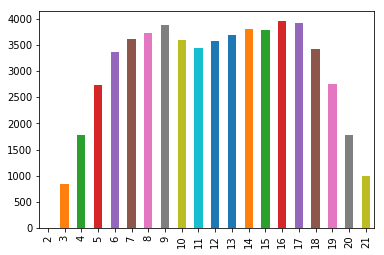

In [0]:
hours.value_counts(sort=False).plot(kind='bar')

In [0]:
bus_df['trans_ts_mod30'] = bus_df.trans_ts.apply(lambda time: time % 30)

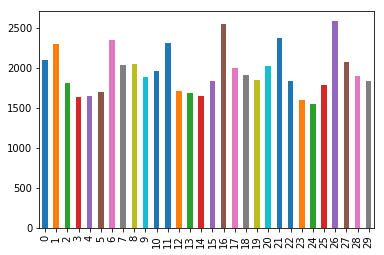

In [0]:
bus_df.trans_ts_mod30.value_counts(sort=False).plot(kind='bar')

In [0]:
labeled_bus_df = bus_df[(bus_df.label != '-') & (bus_df.label != '?')]
labeled_bus_df.head()

,log,lat,request_ts,trans_ts,label,request_ts_datetime,trans_ts_datetime,trans_ts_mod30
0,30.295780,59.932167,1511956827,1511956594,0,2017-11-29 12:00:27,2017-11-29 11:56:34,4
8,30.385973,59.944260,1511956827,1511956782,0,2017-11-29 12:00:27,2017-11-29 11:59:42,12
13,30.374880,59.938213,1511956827,1511956802,1,2017-11-29 12:00:27,2017-11-29 12:00:02,2
17,30.347544,59.932667,1511956827,1511956811,0,2017-11-29 12:00:27,2017-11-29 12:00:11,11
23,30.312321,59.937405,1511956827,1511956820,2,2017-11-29 12:00:27,2017-11-29 12:00:20,20


In [0]:
labeled_bus_df.shape

(10000, 8)

In [0]:
labeled_bus_df.groupby(by='trans_ts_mod30')['label'].value_counts().head()

trans_ts_mod30  label
0               0        172
                1        129
                2         60
1               0        177
                1        130
Name: label, dtype: int64

In [0]:
labeled_bus_df.sort_values(by='trans_ts_datetime').iloc[:10, :]

,log,lat,request_ts,trans_ts,label,request_ts_datetime,trans_ts_datetime,trans_ts_mod30
0,30.295780,59.932167,1511956827,1511956594,0,2017-11-29 12:00:27,2017-11-29 11:56:34,4
8,30.385973,59.944260,1511956827,1511956782,0,2017-11-29 12:00:27,2017-11-29 11:59:42,12
13,30.374880,59.938213,1511956827,1511956802,1,2017-11-29 12:00:27,2017-11-29 12:00:02,2
17,30.347544,59.932667,1511956827,1511956811,0,2017-11-29 12:00:27,2017-11-29 12:00:11,11
23,30.312321,59.937405,1511956827,1511956820,2,2017-11-29 12:00:27,2017-11-29 12:00:20,20
25,30.358715,59.931366,1511956858,1511956834,0,2017-11-29 12:00:58,2017-11-29 12:00:34,4
28,30.313391,59.936810,1511956858,1511956849,1,2017-11-29 12:00:58,2017-11-29 12:00:49,19
30,30.337549,59.934029,1511956888,1511956857,0,2017-11-29 12:01:28,2017-11-29 12:00:57,27
36,30.358793,59.931267,1511956918,1511956896,0,2017-11-29 12:01:58,2017-11-29 12:01:36,6
37,30.339293,59.933846,1511956918,1511956896,0,2017-11-29 12:01:58,2017-11-29 12:01:36,6
